In [358]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import signal 
import math
# Set a wider linewidth for printing
np.set_printoptions(linewidth=300) # Adjust as needed
np.set_printoptions(precision=4) # Adjust as needed

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
(1.0000079024725306+4.86013686322191e-17j)


/var/folders/t4/f61pdd9x60nbtc7tlcsj1fs80000gn/T/ipykernel_91044/2894507668.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  v1[0:15,:] = np.flipud(x0[:, n:n+15].T).copy() # select next 15 inputs samples
/var/folders/t4/f61pdd9x60nbtc7tlcsj1fs80000gn/T/ipykernel_91044/2894507668.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  v2[k] = reg1[k, 0:16:2].reshape(1,8, order='F') @ hh1[k, :].reshape(8,1, order='F') # Top 15, odd index
/var/folders/t4/f61pdd9x60nbtc7tlcsj1fs80000gn/T/ipykernel_91044/2894507668.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  v2[k+15] = reg1[k+15, 1:16:2].reshape(1,8, order='F') @ hh1[k+15, :].reshape(8,1, order='F') # Bottom 15, even index


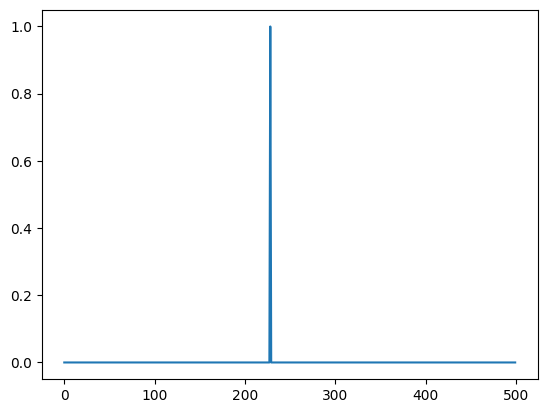

In [4]:
a = np.zeros((1, 2))
b = np.reshape([1], (1, 1))
c = np.zeros((1,500), dtype=complex)
x0 = np.hstack((a, b, c))  # shape of (1, 503)
x2 = np.zeros((1, 500), dtype=complex)
n_theta = np.arange(-(4-1/30), 4, 1/30).reshape(1, 239, order='F')
kaiser_window = np.kaiser(239, 8).reshape(1, 239, order='F')
h1 = np.sinc(n_theta) * kaiser_window # windowed sinc
hh1 = np.hstack((np.zeros((1,1), dtype=complex), h1)).reshape(30, 8, order='F').copy() # append leading zero and map to 2D array
# np.arange(1, 9, 1).reshape(2, 4, order="F") for debugging purpose
h2 = np.sinc(n_theta*2.015) * kaiser_window
h2 = h2/np.sum(h2)

hh2 = np.hstack((np.zeros((1,1), dtype=complex), h2)).reshape(30, 8, order='F').copy() # append leading zero and map to 2D array 
m2 = 0 # output clock, synthesis channelizer

v1 = np.zeros((1, 30)).T # input vector, analysis
v2 = np.zeros((1, 30)).T # output of polyphase filter
v3 = np.zeros((1, 30)).T # output of IFFT
reg1 = np.zeros((30, 16)) # polyphase filter 2D register

u3 = np.zeros((1, 30)).T # input vector, synthesis
u2 = np.zeros((1, 30)).T # output of IFFT
u1 = np.zeros((1, 15), dtype=complex).T # output of Polyphase filter
reg2 = np.zeros((30, 16)) # polyphase filter 2D register
flg1 = 0; # state flag for analysis circular buffer
flg2 = 0; # state flag for synthesis circular buffer

for n in range(0, x0.shape[1], 15):
    try:
        v1[0:15,:] = np.flipud(x0[:, n:n+15].T).copy() # select next 15 inputs samples
    except:
        pass
    
    v1[15:30,:] = v1[0:15,:].copy()   # copy top inputs to bottom inputs
    reg1 = np.hstack((v1, reg1[:, 0:15])).copy()
    #print(reg1[0, 0:16:2].reshape(1,8) @ hh1[0, :].reshape(8,1))
    for k in range(15):
        v2[k] = reg1[k, 0:16:2].reshape(1,8, order='F') @ hh1[k, :].reshape(8,1, order='F') # Top 15, odd index
        v2[k+15] = reg1[k+15, 1:16:2].reshape(1,8, order='F') @ hh1[k+15, :].reshape(8,1, order='F') # Bottom 15, even index
    if flg1 == 0:
        flg1 = 1
    else:
        flg1 = 0
        v2 = np.vstack((v2[15:30], v2[0:15]))
    v3 = 30*np.fft.ifft(v2[:,0])
    v3 = v3.reshape(30,1, order='F')
    # print(np.ones((1,5)).T.shape)
#    u3 = v3 * np.vstack((np.ones((1,5)).T, np.zeros((1,21)).T, np.ones((1,4)).T))
   # print(v3)
    u3 = v3 * np.array([[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]])
    #print(u3.shape)
    #print(v3.shape)
    u2 = 15*np.fft.ifft(u3[:,0])
    u2 = u2.reshape(30,1, order='F')
    if flg2 == 0:
        flg2 = 1
    else:
        flg2 = 0
        u2 = np.vstack((u2[15:30], u2[0:15]))
    reg2 = np.hstack((u2, reg2[:, 0:15]))
    for k in range(15):
        u_top = reg2[k, 0:16:2].reshape(1,8, order='F') @ hh2[k, :].reshape(8,1, order='F') # Top 15, odd index
        u_bottom = reg2[k+15, 1:16:2].reshape(1,8, order='F') @ hh2[k+15, :].reshape(8,1, order='F') # Bottom 15, even index
        u1[k] = u_top + u_bottom
    try:
      x2[:, m2:m2+15] = u1.T
    except:
      pass
    m2 = m2+15
plt.plot((x2.T))
print(x2[0,228])